# Introduction

This project focuses on the detection of email spam using a dataset obtained from Kaggle. Email spam, commonly referred to as "junk" mail, is an ever-present issue for both individuals and organizations. Effective identification of spam messages is essential to enhance security and reduce unwanted communications.

The objective of this project is to analyze the dataset and build a machine learning model capable of classifying emails as either spam or "ham" (non-spam). After experimenting with various models, we have identified the Support Vector Machine (SVM) as the most effective model for this task. Using the `sklearn.svm.SVC` implementation of SVM, the model aims to demonstrate superior performance in distinguishing between spam and legitimate emails, ensuring high accuracy in real-world applications.


In [40]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import nltk
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AjBorbz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
p = Path(Path.cwd()).resolve().parents[1] / "sample_datasets" / "spam_ham_dataset.csv"

df = pd.read_csv(p)
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [24]:
df.shape

(5171, 4)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5171.0,2585.000000,1492.883452,0.0,1292.5,2585.0,3877.5,5170.0
label_num,5171.0,0.289886,0.453753,0.0,0.0,0.0,1.0,1.0


### Check if the dataset has null values

In [27]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

### Check the dataset's SPAM and HAM distribution

In [28]:
df['label'].value_counts(normalize=True)

label
ham     0.710114
spam    0.289886
Name: proportion, dtype: float64

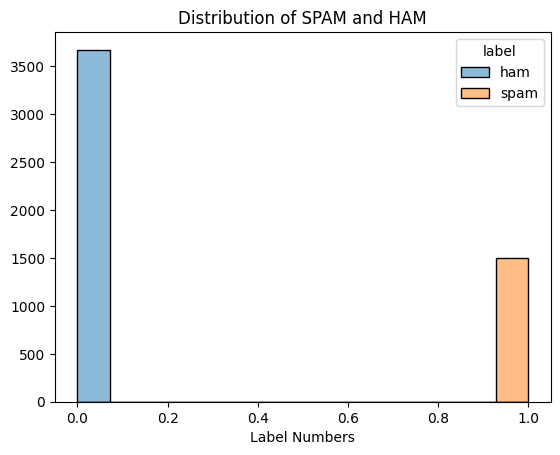

In [29]:
sns.histplot(data=df, x="label_num", hue="label")
plt.title("Distribution of SPAM and HAM")
plt.xlabel("Label Numbers")
plt.ylabel("")
plt.show("Count")

## Data Preprocessing

To ensure the dataset is clean and ready for modeling, several preprocessing steps were undertaken:

1. **Dropping Unnecessary Columns**: The dataset initially contained an "Unnamed: 0" column, which represented a masked version of the email sender. This column is irrelevant to the classification task and was removed to simplify the dataset.

2. **Text Cleaning**: A custom `clean_email_text` function was created to remove non-string punctuation and other irrelevant characters from the email content. This step ensures that only meaningful words are retained for further analysis.

3. **Stopwords Removal**: Stopwords, or common words that do not contribute significant meaning (e.g., "the", "is"), were removed using the `stopwords` list from the sklearn library. This reduces noise in the data and helps the model focus on more important features.

4. **Stemming**: To normalize the text and reduce words to their base forms, the Snowball Stemmer from sklearn was applied. This step reduces word variations and improves the model's ability to generalize patterns in the dataset.


In [30]:
# Remove "Unnamed: 0" column. This is a masked column containing the email sender.
df.drop(["Unnamed: 0"], axis=1, inplace=True)


In [31]:
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [35]:
def clean_email_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    words = text.split()
    stop_words = stopwords.words('english')
    stemmer=SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
    final_words = [word for word in words if word != "subject"]
    return ' '.join(final_words)

### Apply the clean_email_text function to the column 'clean_text'

In [36]:
df['clean_text'] = df['text'].apply(clean_email_text)

#### Check clean_text column

In [37]:
df['clean_text']

0       enron methanol meter 988291 follow note gave m...
1       hpl nom januari 9 2001 see attach file hplnol ...
2       neon retreat ho ho ho around wonder time year ...
3       photoshop window offic cheap main trend abas d...
4       indian spring deal book teco pvr revenu unders...
                              ...                        
5166    put 10 ft transport volum decreas 25000 10000 ...
5167    3 4 2000 follow nom hpl take extra 15 mmcf wee...
5168    calpin daili gas nomin juli mention earlier ho...
5169    industri worksheet august 2000 activ attach wo...
5170    import onlin bank alert dear valu citizensr ba...
Name: clean_text, Length: 5171, dtype: object

### TfidfVectorizer
The TfidfVectorizer is a tool from the sklearn.feature_extraction.text module in Python, commonly used for transforming text data into numerical features that machine learning models can understand. It is based on TF-IDF (Term Frequency-Inverse Document Frequency), a popular technique for text representation.

# Importance of TfidfVectorizer in Email Spam Detection

The `TfidfVectorizer` is a crucial component in this email spam detection project as it transforms raw email text into numerical features that machine learning models can process. Below are the key reasons why it plays a vital role:

### 1. **Feature Extraction**
- **Text to Numbers**: Emails are unstructured text, which needs to be converted into numerical data for model training. The `TfidfVectorizer` assigns each word in the email a weight based on its importance (TF-IDF score).
- **Meaningful Representation**: It emphasizes words that help distinguish between spam and ham (non-spam) emails. Words like "free", "win", or "offer" in spam emails get higher weights, while common words like "the", "is" are given less importance.

### 2. **Handling Noise**
- **Reduction of Common Words**: Both spam and ham emails share many common words (e.g., "and", "the"). The vectorizer assigns lower scores to such words, reducing their influence, which allows the model to focus on more informative words.
- **Improved Signal-to-Noise Ratio**: By emphasizing relevant words, `TfidfVectorizer` filters out noise, ensuring that only meaningful terms remain for model training.

### 3. **Improved Model Performance**
- **Spam and Ham Differentiation**: Certain keywords are strong indicators of spam (e.g., "win", "prize"), while others are typical of non-spam emails (e.g., "work", "meeting"). The vectorizer ensures that the model understands the relative importance of these terms.
- **Balanced Word Frequency**: By balancing word frequency across documents, the model is better at generalizing to new email data and improving classification accuracy.

### 4. **Dimensionality Reduction**
- The vectorizer reduces the dataset to only important words, ignoring terms common to all emails. This prevents overfitting and ensures that the model remains generalizable to new email datasets.

### Example in Email Spam Detection:
In spam detection, words like "free", "urgent", and "winner" are more likely to occur in spam emails. The `TfidfVectorizer` assigns higher scores to these terms in spam emails, while down-weighting common words such as "the" and "and", making it easier for the model to identify spam.

### Conclusion:
The `TfidfVectorizer` is essential for:
- Converting raw email text into numerical data for the model.
- Highlighting words that are relevant for distinguishing spam from ham.
- Reducing the impact of non-informative words.
- Enhancing the overall accuracy of spam detection by improving the feature representation.


# Importance of Naive Bayes in Email Spam Detection

Naive Bayes is a simple yet powerful probabilistic machine learning algorithm, widely used for text classification, especially in email spam detection. It applies Bayes' Theorem with the assumption that features are conditionally independent given the class label (this is known as the **Naive** assumption). 

Here’s why Naive Bayes is important for email spam detection:

### 1. **Suitability for Text Classification**:
   - **High-Dimensional Data**: Naive Bayes handles high-dimensional data well, such as the text data processed using `TfidfVectorizer`. It performs efficiently even when there are thousands of words (features) in each email.
   - **Binary Classification**: Email spam detection is a binary classification problem, where the goal is to classify emails as either spam or ham (non-spam). Naive Bayes is particularly good for binary classification, making it an excellent fit for this task.

### 2. **Interpretability**:
   - **Clear Probabilistic Output**: Naive Bayes provides clear probability scores for each class (spam or ham). For example, it gives a probability that a given email belongs to the "spam" class, helping users understand the model’s decision-making process.
   - **Handling of Word Frequencies**: Since it is a word-frequency-based model, Naive Bayes assigns probabilities based on how often certain words (features) appear in spam or ham emails. For example, words like "free", "win", or "click" might have a higher probability of occurring in spam emails.

### 3. **Efficient and Fast**:
   - **Low Computational Cost**: Naive Bayes is computationally efficient and requires fewer resources compared to more complex algorithms. This makes it a great option when processing large datasets or when quick model training is needed.
   - **Real-Time Predictions**: The model makes predictions quickly, which is advantageous in real-time email filtering systems where fast classification is critical.

### 4. **Good Performance with Limited Data**:
   - **Robust with Small Datasets**: Naive Bayes can perform surprisingly well even with small amounts of training data, making it useful in situations where only a limited set of spam and ham emails are available for training.
   - **Works Well with Noisy Data**: Email datasets can be noisy (containing misspellings, formatting errors, etc.), and Naive Bayes is capable of handling such imperfections without a significant drop in performance.

### 5. **Common Naive Bayes Variants**:
   - **Multinomial Naive Bayes**: This is the most common version of Naive Bayes used for text classification, including email spam detection. It assumes that the features (words) are multinomially distributed, which is suitable for text data where we count occurrences of words.
   - **Bernoulli Naive Bayes**: This variant works well when the features are binary, i.e., the presence or absence of certain words (instead of their frequency). It's less commonly used in text classification but may still be useful depending on the dataset.

### Example of Naive Bayes in Email Spam Detection:
Naive Bayes calculates the probability that an email belongs to either the spam or ham class based on the words it contains. For example, if an email contains words like "winner", "lottery", or "urgent", the model might assign a higher probability to the spam class. On the other hand, if the email contains words like "meeting", "project", or "team", it might lean towards the ham class.

### Conclusion:
Naive Bayes is ideal for email spam detection due to its:
- **Efficiency** with large, high-dimensional datasets.
- **Interpretability**, providing probabilistic scores for each classification.
- **Speed** in training and making real-time predictions.
- **Strong performance** with limited or noisy data.



In [43]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['clean_text'])
y = df['label_num']


#### Train Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.20, random_state=42)

In [46]:
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=10000)
}

best_result = {}
best_model_name = None
best_accuracy = 0.0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    best_result[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.2f}\n")
    print(f"Classification Report: \n\t{classification_report(y_test, y_pred)}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

print(f"Best Model: \n{best_model_name} with Accuracy: {best_accuracy:.2f}")
print()

Naive Bayes Accuracy: 0.92

Classification Report: 
	              precision    recall  f1-score   support

           0       0.90      1.00      0.95       742
           1       1.00      0.72      0.84       293

    accuracy                           0.92      1035
   macro avg       0.95      0.86      0.89      1035
weighted avg       0.93      0.92      0.92      1035

SVM Accuracy: 0.99

Classification Report: 
	              precision    recall  f1-score   support

           0       1.00      0.98      0.99       742
           1       0.96      0.99      0.97       293

    accuracy                           0.99      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.99      0.99      0.99      1035

Logistic Regression Accuracy: 0.98

Classification Report: 
	              precision    recall  f1-score   support

           0       1.00      0.98      0.99       742
           1       0.96      0.99      0.97       293

    accuracy           

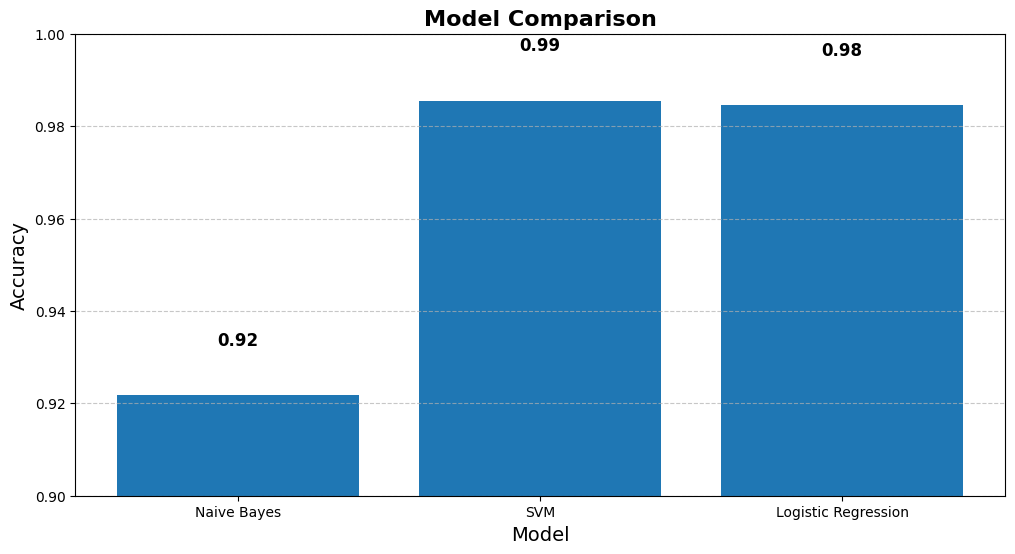

In [48]:

plt.figure(figsize=(12, 6))
bars = plt.bar(best_result.keys(), best_result.values())
plt.title('Model Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.9, 1.0)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()